$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

Use all datas 

# Create Environment

In [95]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=2

global T
global target
T=10
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

global num_action
num_action=8

global obs_para
obs_para=6

global coeff
coeff=[]
for i in range(N+1):
    coeff.append(0.2**(N-i))
print(coeff)

[1.1258999068426271e-35, 5.629499534213136e-35, 2.8147497671065676e-34, 1.4073748835532837e-33, 7.036874417766418e-33, 3.5184372088832087e-32, 1.7592186044416043e-31, 8.796093022208022e-31, 4.39804651110401e-30, 2.199023255552005e-29, 1.0995116277760024e-28, 5.497558138880012e-28, 2.7487790694400056e-27, 1.374389534720003e-26, 6.871947673600013e-26, 3.4359738368000065e-25, 1.717986918400003e-24, 8.589934592000015e-24, 4.294967296000008e-23, 2.1474836480000035e-22, 1.0737418240000018e-21, 5.368709120000009e-21, 2.684354560000004e-20, 1.342177280000002e-19, 6.71088640000001e-19, 3.3554432000000048e-18, 1.6777216000000023e-17, 8.388608000000011e-17, 4.194304000000005e-16, 2.0971520000000026e-15, 1.0485760000000012e-14, 5.2428800000000056e-14, 2.6214400000000027e-13, 1.3107200000000013e-12, 6.5536000000000055e-12, 3.276800000000003e-11, 1.6384000000000013e-10, 8.192000000000005e-10, 4.096000000000002e-09, 2.0480000000000012e-08, 1.0240000000000006e-07, 5.120000000000002e-07, 2.560000000000

In [96]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [97]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    var_theta=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
        var_theta+=vecs[i][2]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    var_theta-=mu_theta**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y,var_theta])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(10-np.sqrt((obs[0]-target[0])**2+(obs[1]-target[1])**2)-10*obs[3]-10*obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [98]:
global lr
lr=0.01
global eps
eps=0.05
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/2],[-1,np.pi/2],[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4],[1,-np.pi/2],[-1,-np.pi/2]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(num_action)
    else:
        result=[]
        for i in range(num_action):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(num_action):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(num_action)]
history_r=[0 for i in range(num_action)]
history_su_next=[0 for i in range(num_action)]
flags=[True for i in range(num_action)]

history_rt=[[[] for i in range(num_action)] for j in range(N+1)]
history_sut=[[[] for i in range(num_action)] for j in range(N+1)]
flags_t=[[True for i in range(num_action)] for j in range(N+1)]

# Simulation


In [99]:
num_iter=80

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(num_action)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(num_action)]
    
    '''
    coeff=[]
    for i in range(N):
        coeff.append((np.random.random()-0.5)/100+0.8**(N-i))
    coeff.append(1)
    #print(coeff)
    '''
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,obs_para)
                history_su_next[u_k] = observation_new.reshape(-1,obs_para)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(num_action):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-6).fit(np.array(history_su[j]).reshape(-1,obs_para), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(num_action):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-6).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(num_action):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-6).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|█                                                                                  | 1/80 [00:00<00:44,  1.76it/s]

observation = [-2.09796841e+00 -2.80593633e+00  1.72787596e+00  1.68465755e-03
  4.65348400e-04  3.73194416e-03]


  2%|██                                                                                 | 2/80 [00:01<00:46,  1.69it/s]

observation = [-2.44275929e+00 -9.35324474e-01  1.77635684e-15  8.79428757e-03
  9.10487390e-03  4.93480220e-02]


  4%|███                                                                                | 3/80 [00:01<00:47,  1.63it/s]

observation = [-2.56503997e+00 -1.94985211e+00 -6.28318531e-01  3.51519752e-04
  3.89822027e-03  3.99718978e-02]


  5%|████▏                                                                              | 4/80 [00:02<00:45,  1.66it/s]

observation = [-0.17466016 -0.3254483  -1.09955743  0.02490161  0.0550619   0.0335875 ]


  6%|█████▏                                                                             | 5/80 [00:03<00:46,  1.63it/s]

observation = [-3.42915220e+00 -1.65135341e+00 -1.72787596e+00  9.32327835e-03
  6.97076097e-04  2.59385541e-02]


  8%|██████▏                                                                            | 6/80 [00:03<00:47,  1.56it/s]

observation = [-3.98103276e+00 -1.47432240e+00 -2.04203522e+00  3.59796150e-04
  8.13671379e-02  2.24841925e-02]


  9%|███████▎                                                                           | 7/80 [00:04<00:48,  1.51it/s]

observation = [ 1.75013029e+00 -1.63267765e+00 -1.09955743e+00  1.51225187e-02
  3.82028088e-05  1.51128317e-03]


 10%|████████▎                                                                          | 8/80 [00:05<00:49,  1.45it/s]

observation = [ 1.44280719e+00 -1.39339026e+00 -9.42477796e-01  1.40660069e-02
  4.59985748e-04  1.11033050e-03]


 11%|█████████▎                                                                         | 9/80 [00:05<00:51,  1.39it/s]

observation = [ 1.94840164e+00 -1.38315775e+00 -9.42477796e-01  2.03666005e-02
  3.56615611e-04  1.11033050e-03]


 12%|██████████▎                                                                       | 10/80 [00:06<00:52,  1.32it/s]

observation = [ 2.40799629e+00 -1.82942226e+00 -4.71238898e-01  2.02048469e-02
  6.64093837e-05  2.77582624e-04]


 14%|███████████▎                                                                      | 11/80 [00:07<00:54,  1.26it/s]

observation = [-3.40067505e+00 -1.53750033e+00 -1.88495559e+00  9.06861934e-04
  5.22204134e-02  2.41805308e-02]


 15%|████████████▎                                                                     | 12/80 [00:08<00:56,  1.20it/s]

observation = [ 1.94842352e+00 -1.61273128e+00 -4.71238898e-01  1.48016712e-02
  3.63157121e-04  2.77582624e-04]


 16%|█████████████▎                                                                    | 13/80 [00:09<00:59,  1.13it/s]

observation = [ 3.38219440e+00 -1.80944813e+00 -6.28318531e-01  2.61867924e-02
  8.69353652e-05  4.93480220e-04]


 18%|██████████████▎                                                                   | 14/80 [00:10<01:01,  1.08it/s]

observation = [ 1.09063856e+00 -1.11709714e+00 -1.57079633e-01  7.81838106e-03
  3.32814463e-03  3.08425138e-05]


 19%|███████████████▍                                                                  | 15/80 [00:11<01:03,  1.02it/s]

observation = [ 4.35212316e-01 -1.48790499e+00 -4.71238898e-01  5.62089775e-03
  1.15760720e-03  2.77582624e-04]


 20%|████████████████▍                                                                 | 16/80 [00:12<01:06,  1.03s/it]

observation = [ 1.82661187e+00 -1.25735023e+00  0.00000000e+00  1.21055613e-02
  2.24067393e-03  1.10933565e-32]


 21%|█████████████████▍                                                                | 17/80 [00:14<01:08,  1.09s/it]

observation = [ 1.99190262e+00 -1.09067764e+00 -4.71238898e-01  1.61851275e-02
  3.37788855e-03  2.77582624e-04]


 22%|██████████████████▍                                                               | 18/80 [00:15<01:11,  1.15s/it]

observation = [ 1.59520646e+00 -9.18846497e-01 -1.57079633e-01  1.28596158e-02
  4.92511715e-03  3.08425138e-05]


 24%|███████████████████▍                                                              | 19/80 [00:16<01:13,  1.21s/it]

observation = [ 1.98231479e+00 -7.83673535e-01 -3.14159265e-01  1.59285237e-02
  6.37257552e-03  1.23370055e-04]


 25%|████████████████████▌                                                             | 20/80 [00:18<01:18,  1.31s/it]

observation = [ 2.29416268e+00 -1.00967744e+00 -1.57079633e-01  1.72150260e-02
  4.23691025e-03  3.08425138e-05]


 26%|█████████████████████▌                                                            | 21/80 [00:19<01:21,  1.39s/it]

observation = [ 2.30737175e+00 -9.40337374e-01  5.55111512e-18  1.75815396e-02
  4.88445593e-03  3.82104501e-33]


 28%|██████████████████████▌                                                           | 22/80 [00:21<01:25,  1.48s/it]

observation = [ 2.32083424e+00 -6.70365498e-01 -3.14159265e-01  1.79466428e-02
  7.75232740e-03  1.23370055e-04]


 29%|███████████████████████▌                                                          | 23/80 [00:23<01:28,  1.56s/it]

observation = [ 9.37544523e-01 -8.73314092e-01 -6.28318531e-01  5.30505095e-03
  5.14557044e-03  4.93480220e-04]


 30%|████████████████████████▌                                                         | 24/80 [00:25<01:32,  1.65s/it]

observation = [-2.65771766e+00 -7.76416376e-01 -2.19911486e+00  1.65615393e-03
  1.28182701e-02  2.08495393e-02]


 31%|█████████████████████████▋                                                        | 25/80 [00:27<01:35,  1.74s/it]

observation = [ 1.77865174e+00 -5.81520483e-01 -6.28318531e-01  6.40935035e-03
  6.65500274e-03  4.93480220e-04]


 32%|██████████████████████████▋                                                       | 26/80 [00:29<01:39,  1.84s/it]

observation = [ 1.0265825  -0.64110952 -0.9424778   0.00669438  0.00734621  0.00111033]


 34%|███████████████████████████▋                                                      | 27/80 [00:31<01:42,  1.94s/it]

observation = [ 8.51770708e-01 -2.67257386e-01 -7.85398163e-01  8.13631648e-03
  1.17091844e-02  7.71062844e-04]


 35%|████████████████████████████▋                                                     | 28/80 [00:33<01:47,  2.07s/it]

observation = [ 2.14253910e+00 -3.12265761e-01 -3.14159265e-01  1.33022564e-02
  1.27854483e-02  1.23370055e-04]


 36%|█████████████████████████████▋                                                    | 29/80 [00:36<01:53,  2.22s/it]

observation = [ 1.79597421e+00 -8.52050941e-02 -3.14159265e-01  1.13816408e-02
  1.54264922e-02  1.23370055e-04]


 38%|██████████████████████████████▊                                                   | 30/80 [00:39<01:58,  2.38s/it]

observation = [ 1.08432674e+00 -3.16854815e-01 -3.14159265e-01  3.88226477e-03
  9.61235135e-03  1.23370055e-04]


 39%|███████████████████████████████▊                                                  | 31/80 [00:41<02:04,  2.53s/it]

observation = [ 1.55255922e+00 -6.11723180e-02 -9.42477796e-01  1.15513505e-02
  1.44738004e-02  1.11033050e-03]


 40%|████████████████████████████████▊                                                 | 32/80 [00:44<02:09,  2.69s/it]

observation = [ 1.77331985e+00 -9.89925805e-02 -6.28318531e-01  1.09498717e-02
  1.54874205e-02  4.93480220e-04]


 41%|█████████████████████████████████▊                                                | 33/80 [00:48<02:14,  2.87s/it]

observation = [ 1.55208930e+00  1.65842232e-01 -4.71238898e-01  1.17159209e-02
  1.91187209e-02  2.77582624e-04]


 42%|██████████████████████████████████▊                                               | 34/80 [00:51<02:19,  3.03s/it]

observation = [ 2.21609713e+00  9.17404705e-02 -6.28318531e-01  1.51221339e-02
  1.84785694e-02  4.93480220e-04]


 44%|███████████████████████████████████▉                                              | 35/80 [00:55<02:25,  3.22s/it]

observation = [ 1.88635576e+00  2.46807139e-01 -9.42477796e-01  1.33479789e-02
  2.09372836e-02  1.11033050e-03]


 45%|████████████████████████████████████▉                                             | 36/80 [00:59<02:28,  3.37s/it]

observation = [ 1.66673319e+00 -2.93174621e-01 -6.28318531e-01  8.74213678e-03
  1.26599639e-02  4.93480220e-04]


 46%|█████████████████████████████████████▉                                            | 37/80 [01:03<02:33,  3.56s/it]

observation = [ 1.69723584e+00  4.46919773e-01 -1.09955743e+00  1.47574631e-02
  2.37233032e-02  1.51128317e-03]


 48%|██████████████████████████████████████▉                                           | 38/80 [01:07<02:36,  3.73s/it]

observation = [ 1.31824606e+00  1.03089550e+00 -9.42477796e-01  1.75957748e-02
  3.27378037e-02  1.11033050e-03]


 49%|███████████████████████████████████████▉                                          | 39/80 [01:11<02:40,  3.90s/it]

observation = [ 1.55908767  0.68481735 -1.25663706  0.01187536  0.03076935  0.00197392]


 50%|█████████████████████████████████████████                                         | 40/80 [01:16<02:43,  4.09s/it]

observation = [ 2.12236998e+00  2.89203357e-01 -6.28318531e-01  1.28850993e-02
  2.32893541e-02  4.93480220e-04]


 51%|██████████████████████████████████████████                                        | 41/80 [01:20<02:47,  4.29s/it]

observation = [ 2.09963661e+00  3.82948920e-01 -6.28318531e-01  1.23301440e-02
  2.53322647e-02  4.93480220e-04]


 52%|███████████████████████████████████████████                                       | 42/80 [01:25<02:50,  4.50s/it]

observation = [ 2.40075985e+00  2.97977520e-01 -1.57079633e-01  1.32193881e-02
  2.34952500e-02  3.08425138e-05]


 54%|████████████████████████████████████████████                                      | 43/80 [01:31<02:56,  4.78s/it]

observation = [ 2.70676752e+00  4.26270099e-01 -1.57079633e-01  1.42273433e-02
  2.60549416e-02  3.08425138e-05]


 55%|█████████████████████████████████████████████                                     | 44/80 [01:36<02:59,  4.98s/it]

observation = [ 2.70933417e+00  4.52846744e-01 -3.14159265e-01  1.42785838e-02
  2.67292152e-02  1.23370055e-04]


 56%|██████████████████████████████████████████████▏                                   | 45/80 [01:42<03:04,  5.26s/it]

observation = [3.06824726e+00 5.71234132e-01 4.99600361e-17 1.67342835e-02
 2.93571458e-02 2.10773773e-32]


 57%|███████████████████████████████████████████████▏                                  | 46/80 [01:48<03:06,  5.49s/it]

observation = [-0.60540714 -0.54137865 -1.25663706  0.02166568  0.03775813  0.03158273]


 59%|████████████████████████████████████████████████▏                                 | 47/80 [01:54<03:09,  5.74s/it]

observation = [3.19555255e+00 1.01677093e-02 3.14159265e-01 2.03429913e-02
 1.77296835e-02 1.23370055e-04]


 60%|█████████████████████████████████████████████████▏                                | 48/80 [02:01<03:14,  6.06s/it]

observation = [3.04050373e+00 6.44451065e-01 4.99600361e-17 1.59971912e-02
 3.10238663e-02 2.10773773e-32]


 61%|██████████████████████████████████████████████████▏                               | 49/80 [02:08<03:14,  6.29s/it]

observation = [ 2.61060898e+00  8.16228291e-01 -4.71238898e-01  1.19411716e-02
  3.52100230e-02  2.77582624e-04]


 62%|███████████████████████████████████████████████████▎                              | 50/80 [02:15<03:17,  6.58s/it]

observation = [ 2.62790348e+00  7.91599570e-01 -1.57079633e-01  1.23244531e-02
  3.47336382e-02  3.08425138e-05]


 64%|████████████████████████████████████████████████████▎                             | 51/80 [02:23<03:18,  6.86s/it]

observation = [ 2.25066159e+00  1.21536445e+00 -6.28318531e-01  9.87539716e-03
  4.56034747e-02  4.93480220e-04]


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [02:31<03:25,  7.33s/it]

observation = [ 2.52437614e+00  1.21377666e+00 -4.71238898e-01  1.01069327e-02
  4.52824548e-02  2.77582624e-04]


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [02:40<03:27,  7.68s/it]

observation = [ 2.53611713e+00  1.28478780e+00 -7.85398163e-01  1.03235455e-02
  4.72159436e-02  7.71062844e-04]


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [02:48<03:27,  7.99s/it]

observation = [ 2.51992060e+00  1.16374838e+00 -4.71238898e-01  1.00193064e-02
  4.37086690e-02  2.77582624e-04]


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [02:57<03:27,  8.29s/it]

observation = [-0.61038083 -0.39513884  1.41371669  0.00357375  0.08781398  0.07405288]


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [03:07<03:25,  8.56s/it]

observation = [3.43911458e+00 1.61718569e-01 3.14159265e-01 1.98910595e-02
 2.00002245e-02 1.23370055e-04]


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [03:16<03:24,  8.89s/it]

observation = [ 2.51303525e+00  1.29670139e+00 -4.71238898e-01  9.87326970e-03
  4.74660890e-02  2.77582624e-04]


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [03:26<03:23,  9.25s/it]

observation = [ 1.48812416  0.90595308 -1.57079633  0.00602247  0.03209472  0.00308425]


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [03:37<03:23,  9.69s/it]

observation = [ 1.33573976e+00  1.32597777e-01 -9.42477796e-01  7.34164704e-03
  1.77438463e-02  1.11033050e-03]


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [03:48<03:21, 10.09s/it]

observation = [3.20165773e+00 1.03087102e+00 3.14159265e-01 1.35398648e-02
 3.94832897e-02 1.23370055e-04]


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [04:00<03:21, 10.61s/it]

observation = [3.12087889e+00 1.04832333e+00 3.14159265e-01 1.18370252e-02
 3.87998943e-02 1.23370055e-04]


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [04:12<03:18, 11.00s/it]

observation = [3.22327274e+00 1.13605039e+00 3.14159265e-01 1.40356618e-02
 4.27921556e-02 1.23370055e-04]


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [04:24<03:14, 11.42s/it]

observation = [3.21026275e+00 1.14665853e+00 6.28318531e-01 1.37314270e-02
 4.29599467e-02 4.93480220e-04]


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [04:37<03:10, 11.90s/it]

observation = [ 3.10681288e+00  1.39660025e+00 -1.57079633e-01  1.13566596e-02
  4.98155090e-02  3.08425138e-05]


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [04:51<03:06, 12.40s/it]

observation = [ 2.77433367e+00  1.47863749e+00 -9.42477796e-01  9.89993598e-03
  5.18231334e-02  1.11033050e-03]


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [05:05<03:00, 12.87s/it]

observation = [ 2.67898171e+00  1.48210344e+00 -3.14159265e-01  8.16223970e-03
  5.10968791e-02  1.23370055e-04]


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [05:19<02:53, 13.32s/it]

observation = [ 2.77854489e+00  1.53610106e+00 -3.14159265e-01  1.00040427e-02
  5.39968952e-02  1.23370055e-04]


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [05:34<02:46, 13.86s/it]

observation = [ 3.09652802e+00  1.49035900e+00 -1.57079633e-01  1.11128595e-02
  5.27847166e-02  3.08425138e-05]


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [05:50<02:37, 14.32s/it]

observation = [ 2.70886519e+00  1.58331135e+00 -1.57079633e-01  8.61736121e-03
  5.53062575e-02  3.08425138e-05]


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [06:06<02:28, 14.87s/it]

observation = [ 2.65718508e+00  1.57361657e+00 -6.28318531e-01  7.79262685e-03
  5.35000870e-02  4.93480220e-04]


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [06:23<02:19, 15.44s/it]

observation = [ 2.69891535e+00  1.71980641e+00 -1.09955743e+00  8.47568243e-03
  5.72747744e-02  1.51128317e-03]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [06:39<02:06, 15.80s/it]

observation = [3.33196514e+00 1.46223718e+00 4.71238898e-01 1.07397887e-02
 4.96403839e-02 2.77582624e-04]


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [06:56<01:53, 16.22s/it]

observation = [3.35865564e+00 1.76556446e+00 7.85398163e-01 1.11499356e-02
 6.07803560e-02 7.71062844e-04]


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [07:14<01:39, 16.64s/it]

observation = [3.07641782e+00 1.95892765e+00 1.25663706e+00 6.14518433e-03
 6.33745622e-02 1.97392088e-03]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [07:32<01:25, 17.03s/it]

observation = [3.32592982e+00 1.64681299e+00 7.85398163e-01 1.05350335e-02
 5.59558757e-02 7.71062844e-04]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [07:51<01:10, 17.51s/it]

observation = [ 1.52667657e+00  8.02824615e-01 -9.42477796e-01  6.27876669e-03
  2.75080741e-02  1.11033050e-03]


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [08:11<00:54, 18.29s/it]

observation = [ 3.13485433e+00  1.70286161e+00 -3.14159265e-01  7.00220110e-03
  5.58823949e-02  1.23370055e-04]


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [08:31<00:37, 18.74s/it]

observation = [2.87908284e+00 1.71973849e+00 1.57079633e-01 6.97292419e-03
 5.82065961e-02 3.08425138e-05]


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [08:51<00:19, 19.19s/it]

observation = [2.88792900e+00 1.72535569e+00 1.57079633e-01 7.11063151e-03
 5.85775431e-02 3.08425138e-05]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [09:12<00:00,  6.91s/it]

observation = [3.54988771 2.07763662 1.72787596 0.00955898 0.07009234 0.00373194]


# Results

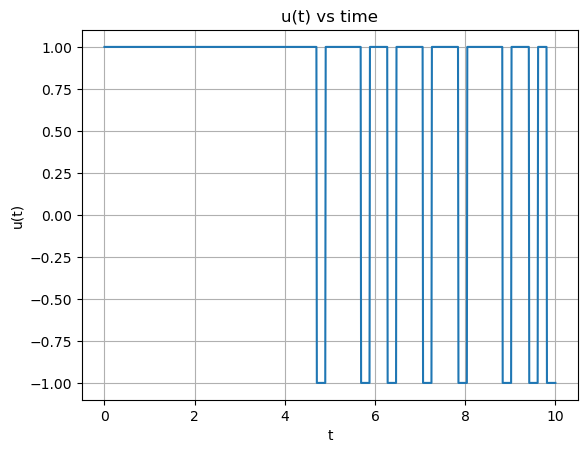

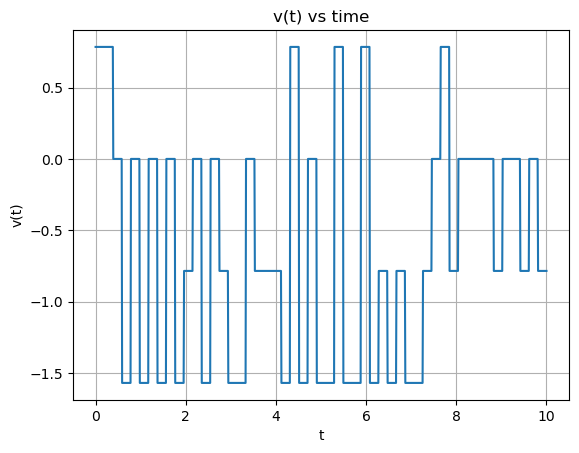

In [100]:
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


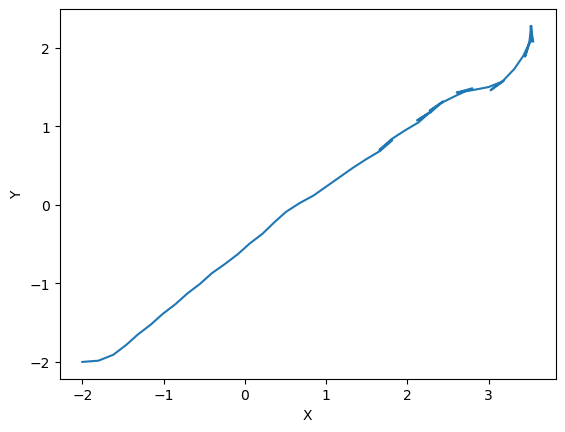

In [101]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

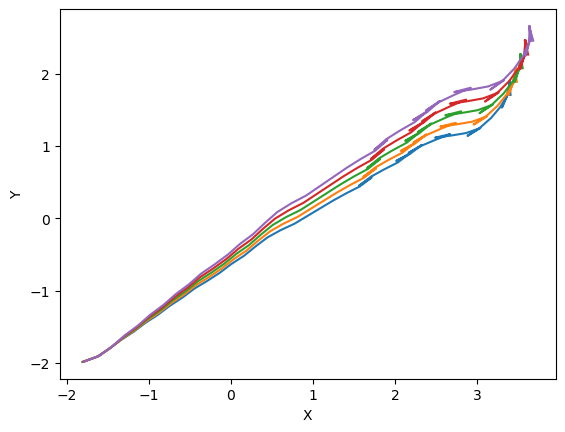

3.053180263676034


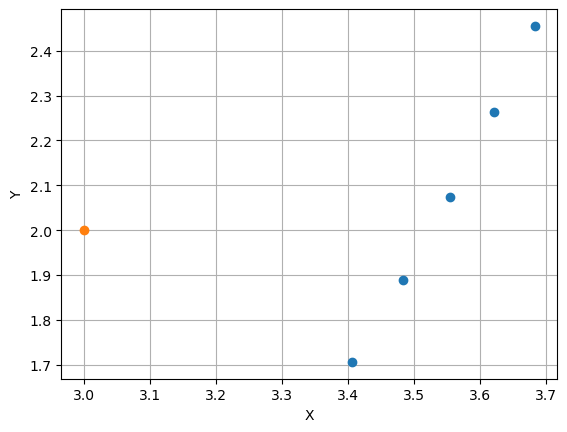

In [102]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


## Best Trajectory

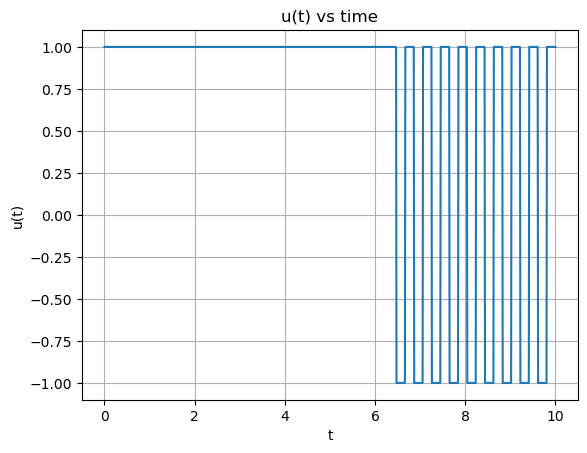

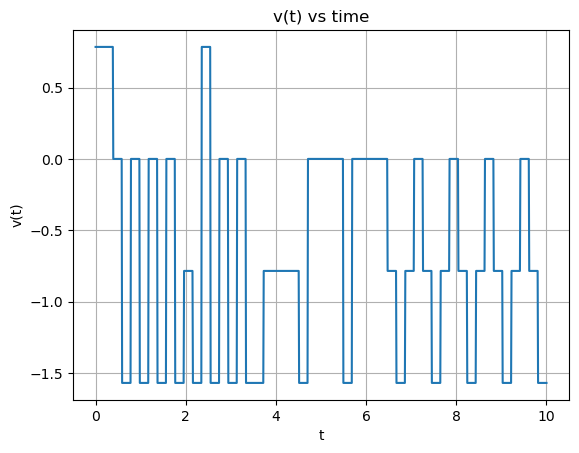

In [103]:
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

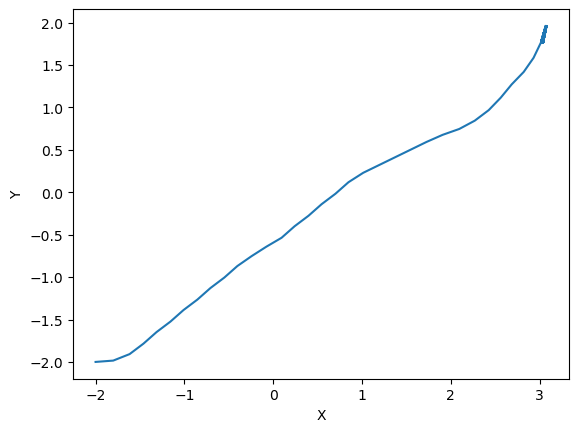

In [104]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

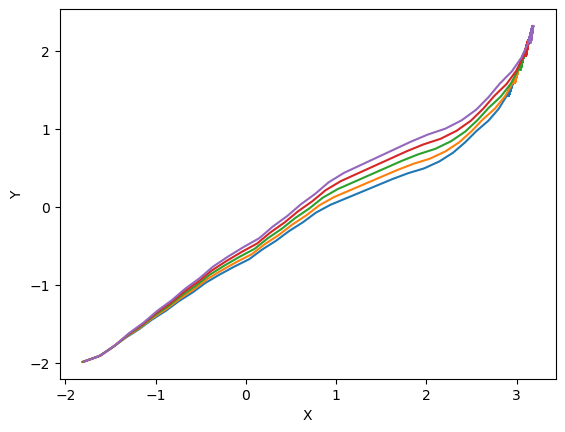

1.267346160441952


In [105]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

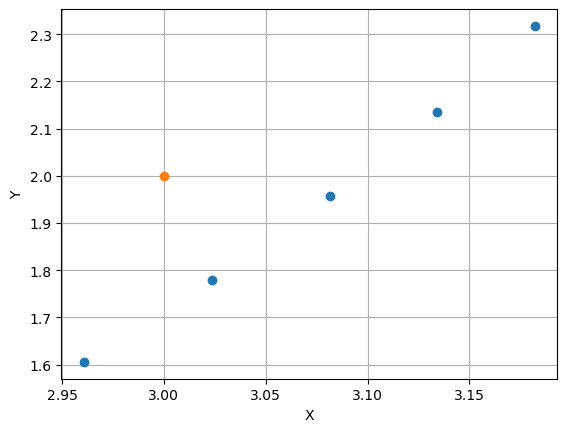

In [106]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

## Pure Exploitation Trajectory

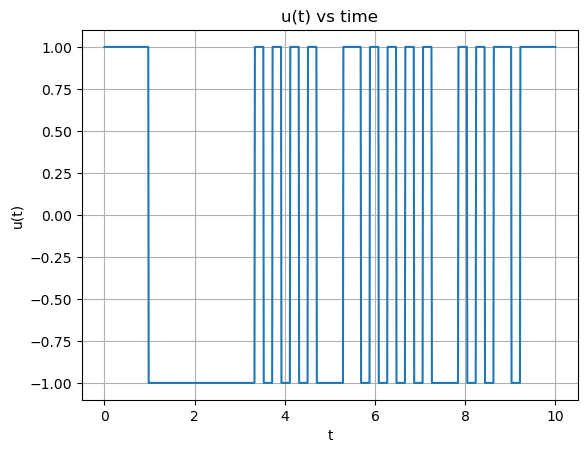

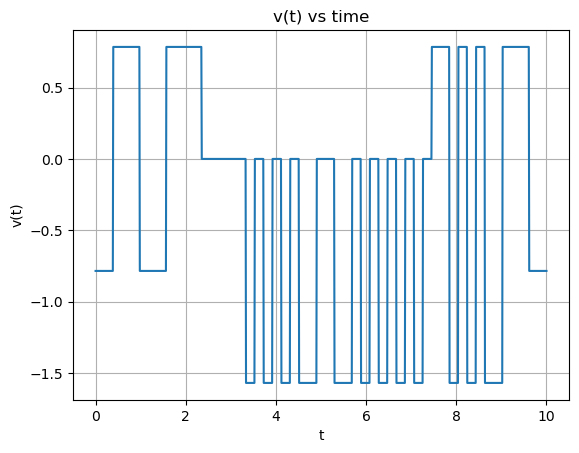

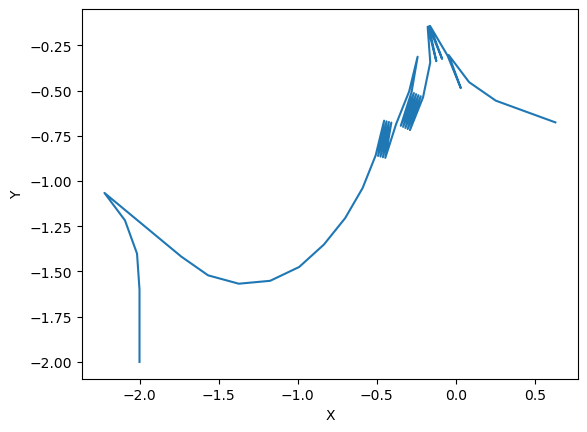

In [107]:
position=np.array([[-2,-2,np.pi/2] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

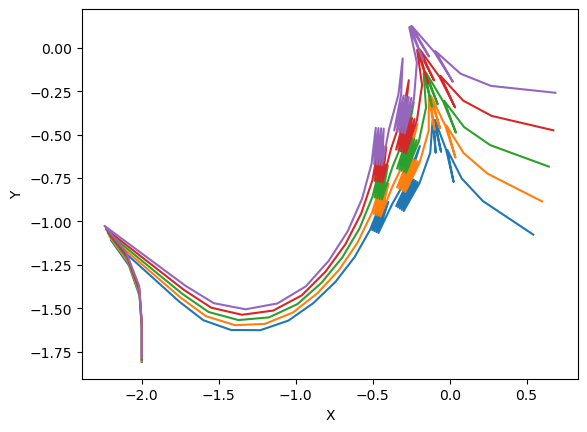

17.891408812025542


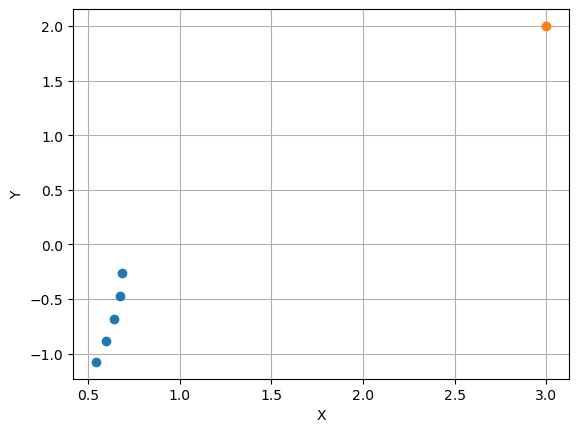

In [108]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()